In [6]:
pip install keras-tuner

     |████████████████████████████████| 129 kB 22.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


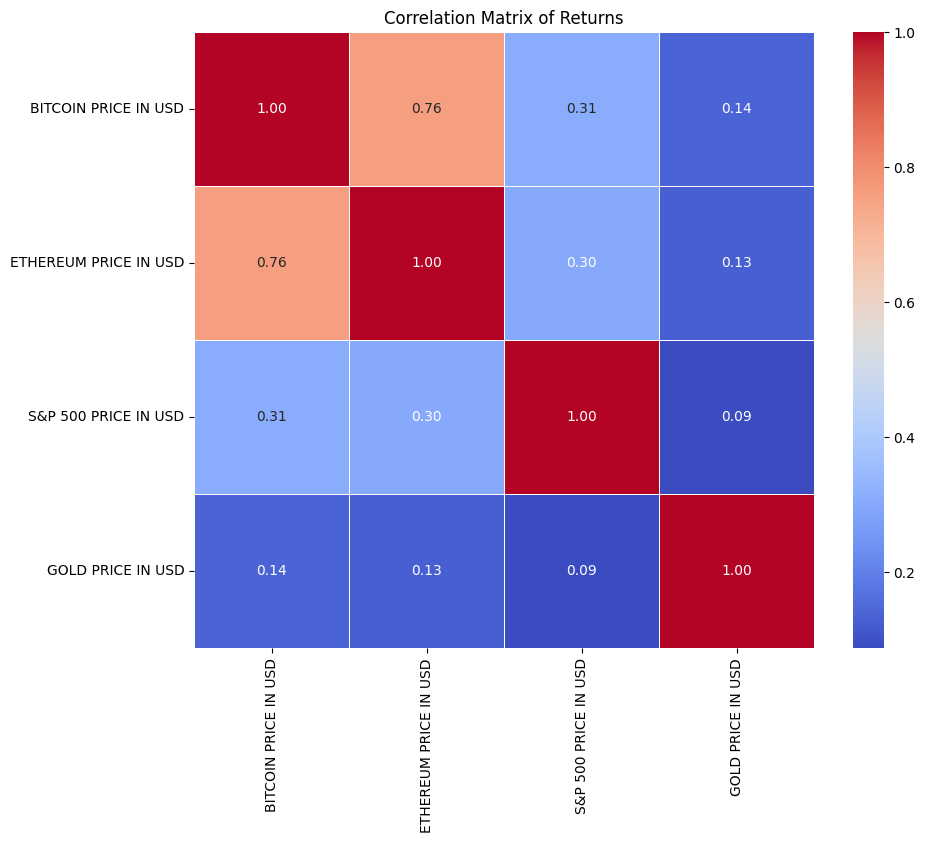

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
DataCapstone = pd.read_csv('DataCapstone.csv', delimiter=';', decimal=',')

# Select relevant features using the given column names
btc_col = 'BITCOIN PRICE IN USD'
eth_col = 'ETHEREUM PRICE IN USD'
sp500_col = 'S&P 500 PRICE IN USD'
gold_col = 'GOLD PRICE IN USD'
features = [btc_col, eth_col, sp500_col, gold_col]

# Calculate simple returns
def calculate_returns(prices):
    return prices.pct_change().dropna()

returns_data = DataCapstone[features].apply(calculate_returns)

# Calculate the correlation matrix of returns
correlation_matrix = returns_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Returns')
plt.show()

Trial 20 Complete [00h 00m 53s]
val_mean_absolute_error: 0.4653280973434448

Best val_mean_absolute_error So Far: 0.4574694335460663
Total elapsed time: 4d 00h 47m 53s

Best Hyperparameters:
Units1: 64
Units2: 160
Dropout1: 0.30000000000000004
Dropout2: 0.1
Learning Rate: 0.004105492333738879
9/9 [==============================] - 1s 19ms/step - loss: 0.1969 - mean_absolute_error: 0.4682
Best Model Test Loss: 0.19690842926502228, Test MAE: 0.4682048559188843
9/9 [==============================] - 1s 17ms/step

Bitcoin Prediction Metrics:
Mean Absolute Error: 0.02086362968509763
Mean Absolute Percentage Error: 1201264336347806.0%
R-squared Score: 0.014481766415873065

Ethereum Prediction Metrics:
Mean Absolute Error: 0.022461216515328137
Mean Absolute Percentage Error: 205.2861682016114%
R-squared Score: -0.00519003219043257


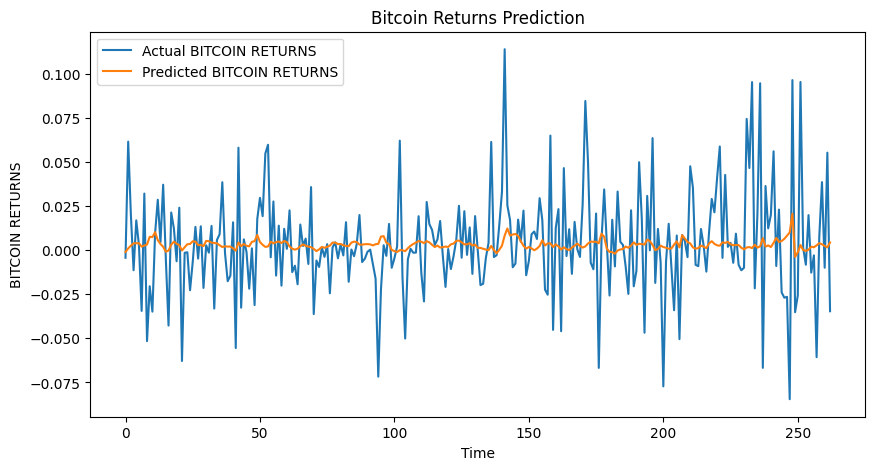

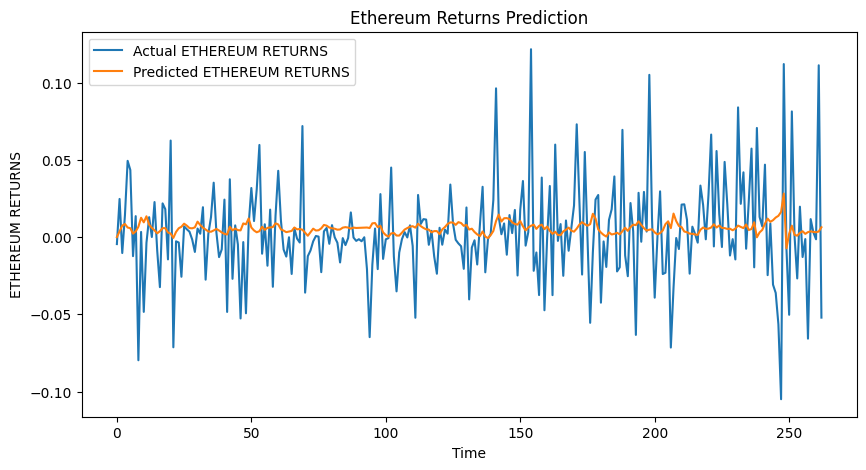

KeyError: 'loss'

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.losses import Huber
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

# Load the CSV file into a DataFrame
DataCapstone = pd.read_csv('DataCapstone.csv', delimiter=';', decimal=',')

# Select relevant features using the given column names
btc_col = 'BITCOIN PRICE IN USD'
eth_col = 'ETHEREUM PRICE IN USD'
sp500_col = 'S&P 500 PRICE IN USD'
gold_col = 'GOLD PRICE IN USD'
features = [btc_col, eth_col, sp500_col, gold_col]

# Calculate simple returns
def calculate_returns(prices):
    return prices.pct_change().dropna()

returns_data = DataCapstone[features].apply(calculate_returns)

# Normalize the returns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(returns_data)

# Convert to supervised format
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length][:2])  # Only Bitcoin and Ethereum returns as targets
    return np.array(x), np.array(y)

# Define sequence length
SEQ_LENGTH = 60
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split data into training and test sets
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {x_train.shape}, Test samples: {x_test.shape}")

# Custom evaluation metric
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.where(y_true == 0, np.nan, y_true)  # Avoid division by zero
    return np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100

# Define a function to build the LSTM model
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units1', min_value=32, max_value=256, step=32),
                       return_sequences=True, input_shape=(SEQ_LENGTH, len(features))))
        model.add(Dropout(rate=hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(LSTM(units=hp.Int('units2', min_value=32, max_value=256, step=32)))
        model.add(Dropout(rate=hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(2))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                      loss=Huber(),
                      metrics=['mean_absolute_error'])
        return model

# Initialize the hypermodel
hypermodel = MyHyperModel()

# Setup the tuner
tuner = RandomSearch(hypermodel,
                     objective='val_mean_absolute_error',
                     max_trials=20,
                     executions_per_trial=1,
                     directory='lstm_hyperparam_tuning',
                     project_name='bitcoin_eth_returns')

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Run the search with early stopping
tuner.search(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=32, callbacks=[early_stopping])

# Retrieve the best model and parameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("\nBest Hyperparameters:")
print(f"Units1: {best_hyperparameters.get('units1')}")
print(f"Units2: {best_hyperparameters.get('units2')}")
print(f"Dropout1: {best_hyperparameters.get('dropout1')}")
print(f"Dropout2: {best_hyperparameters.get('dropout2')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

# Evaluate the best model
loss, mae = best_model.evaluate(x_test, y_test)
print(f"Best Model Test Loss: {loss}, Test MAE: {mae}")

# Predict on test data
predictions = best_model.predict(x_test)

# Inverse transform predictions and actual values to their original scale
y_test_inv = scaler.inverse_transform(np.concatenate([y_test, np.zeros((len(y_test), len(features) - 2))], axis=1))[:, :2]
predictions_inv = scaler.inverse_transform(np.concatenate([predictions, np.zeros((len(predictions), len(features) - 2))], axis=1))[:, :2]

btc_actual = y_test_inv[:, 0]
eth_actual = y_test_inv[:, 1]
btc_predictions = predictions_inv[:, 0]
eth_predictions = predictions_inv[:, 1]

btc_mae = mean_absolute_error(btc_actual, btc_predictions)
btc_mape = mean_absolute_percentage_error(btc_actual, btc_predictions)
btc_r2 = r2_score(btc_actual, btc_predictions)

eth_mae = mean_absolute_error(eth_actual, eth_predictions)
eth_mape = mean_absolute_percentage_error(eth_actual, eth_predictions)
eth_r2 = r2_score(eth_actual, eth_predictions)

# Print evaluation metrics
print("\nBitcoin Prediction Metrics:")
print(f"Mean Absolute Error: {btc_mae}")
print(f"Mean Absolute Percentage Error: {btc_mape}%")
print(f"R-squared Score: {btc_r2}")

print("\nEthereum Prediction Metrics:")
print(f"Mean Absolute Error: {eth_mae}")
print(f"Mean Absolute Percentage Error: {eth_mape}%")
print(f"R-squared Score: {eth_r2}")

# Plot predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(btc_actual, label='Actual BITCOIN RETURNS')
plt.plot(btc_predictions, label='Predicted BITCOIN RETURNS')
plt.legend()
plt.xlabel('Time')
plt.ylabel('BITCOIN RETURNS')
plt.title('Bitcoin Returns Prediction')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(eth_actual, label='Actual ETHEREUM RETURNS')
plt.plot(eth_predictions, label='Predicted ETHEREUM RETURNS')
plt.legend()
plt.xlabel('Time')
plt.ylabel('ETHEREUM RETURNS')
plt.title('Ethereum Returns Prediction')
plt.show()

# Plot training and validation loss
history = best_model.history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

Training samples: (1004, 60, 12), Test samples: (252, 60, 12)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            19712     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 52,866
Trainable params: 52,866
Non-trainable params: 0
________________________________________________________

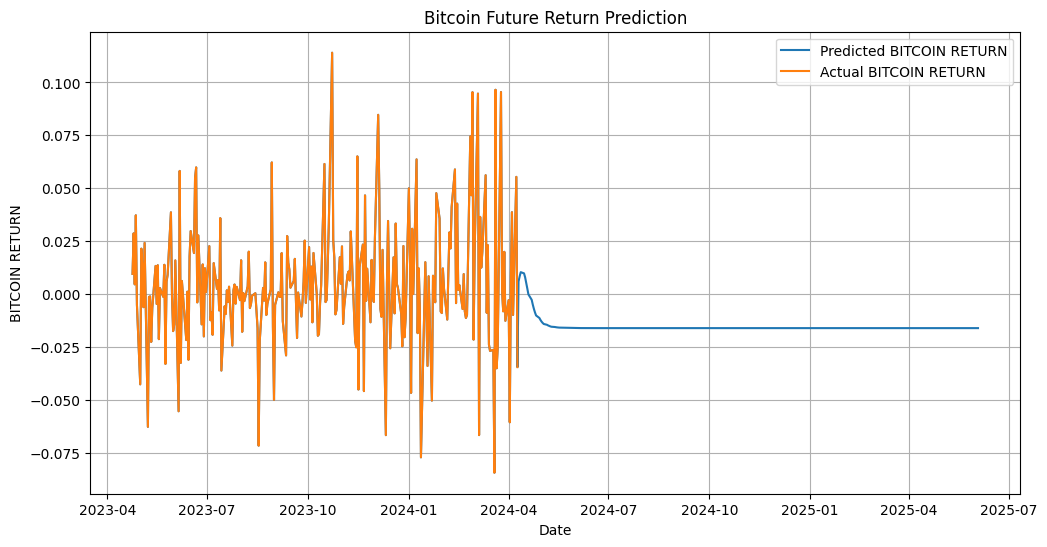

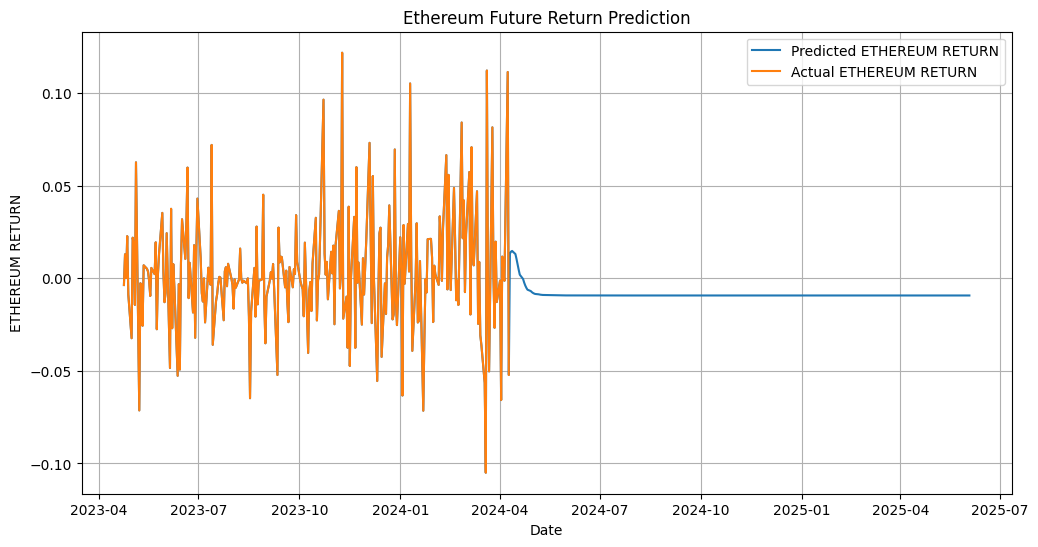

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
DataCapstone = pd.read_csv('DataCapstone.csv', delimiter=';', decimal=',')

# Convert the 'Date' column to datetime
DataCapstone['Date'] = pd.to_datetime(DataCapstone['Date'], format='%d/%m/%Y')

# Set the 'Date' column as the index
DataCapstone.set_index('Date', inplace=True)

# Select relevant features using the given column names
btc_col = 'BITCOIN PRICE IN USD'
eth_col = 'ETHEREUM PRICE IN USD'
sp500_col = 'S&P 500 PRICE IN USD'
gold_col = 'GOLD PRICE IN USD'
features = [btc_col, eth_col, sp500_col, gold_col]

# Calculate returns
DataCapstone['BTC_RETURN'] = DataCapstone[btc_col].pct_change()
DataCapstone['ETH_RETURN'] = DataCapstone[eth_col].pct_change()

# Drop the first row with NaN values resulting from the returns calculation
DataCapstone = DataCapstone.dropna()

# Calculate correlations and add as features
DataCapstone['BTC_ETH_CORR'] = DataCapstone[btc_col].rolling(window=60).corr(DataCapstone[eth_col])
DataCapstone['BTC_SP500_CORR'] = DataCapstone[btc_col].rolling(window=60).corr(DataCapstone[sp500_col])
DataCapstone['BTC_GOLD_CORR'] = DataCapstone[btc_col].rolling(window=60).corr(DataCapstone[gold_col])
DataCapstone['ETH_BTC_CORR'] = DataCapstone[eth_col].rolling(window=60).corr(DataCapstone[btc_col])
DataCapstone['ETH_SP500_CORR'] = DataCapstone[eth_col].rolling(window=60).corr(DataCapstone[sp500_col])
DataCapstone['ETH_GOLD_CORR'] = DataCapstone[eth_col].rolling(window=60).corr(DataCapstone[gold_col])

# Drop initial NaN values from correlation calculations
DataCapstone = DataCapstone.dropna()

# Normalize the features including the returns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(DataCapstone[features + ['BTC_RETURN', 'ETH_RETURN', 'BTC_ETH_CORR', 'BTC_SP500_CORR', 'BTC_GOLD_CORR', 'ETH_BTC_CORR', 'ETH_SP500_CORR', 'ETH_GOLD_CORR']])

# Convert to supervised format
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length, [features.index(btc_col) + 4, features.index(eth_col) + 4]])  # Only Bitcoin and Ethereum returns as targets
    return np.array(x), np.array(y)

# Define sequence length
SEQ_LENGTH = 60
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split data into training and test sets
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {x_train.shape}, Test samples: {x_test.shape}")

# Define the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, x_train.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(2)  # Predict Bitcoin and Ethereum returns only
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summarize the model
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

# Predict on test data
predictions = model.predict(x_test)

# Inverse transform predictions and actual values to their original scale
y_test_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), len(features))), y_test, np.zeros((len(y_test), 6))], axis=1))[:, len(features):len(features)+2]
predictions_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), len(features))), predictions, np.zeros((len(predictions), 6))], axis=1))[:, len(features):len(features)+2]

# Function to predict future data
def predict_future(model, last_sequence, n_future, scaler, features_len):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_future):
        prediction = model.predict(current_sequence[np.newaxis, :, :])
        full_prediction = np.concatenate([np.zeros((1, features_len)), prediction, np.zeros((1, 6))], axis=1)
        future_predictions.append(prediction[0])
        current_sequence = np.vstack([current_sequence[1:], full_prediction])
    
    future_predictions = np.array(future_predictions)
    return future_predictions

# Predict the next 300 future values
last_sequence = x_test[-1]
n_future = 300
future_predictions = predict_future(model, last_sequence, n_future, scaler, len(features))

# Inverse transform predictions to the original scale
future_predictions_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(future_predictions), len(features))), future_predictions, np.zeros((len(future_predictions), 6))], axis=1))[:, len(features):len(features)+2]

# Generate date range for future predictions
last_date = DataCapstone.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_future + 1, freq='B')[1:]  # Use business days

# Combine historical and future data for Bitcoin predictions
bitcoin_full_dates = np.concatenate([DataCapstone.index[-len(y_test_inv):].to_numpy(), future_dates])
bitcoin_full_predictions = np.concatenate([y_test_inv[:, 0], future_predictions_inv[:, 0]])

# Combine historical and future data for Ethereum predictions
ethereum_full_dates = np.concatenate([DataCapstone.index[-len(y_test_inv):].to_numpy(), future_dates])
ethereum_full_predictions = np.concatenate([y_test_inv[:, 1], future_predictions_inv[:, 1]])

# Convert all dates to datetime format
bitcoin_full_dates = pd.to_datetime(bitcoin_full_dates)
ethereum_full_dates = pd.to_datetime(ethereum_full_dates)

# Plot future predictions vs historical data for Bitcoin returns
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_full_dates, bitcoin_full_predictions, label='Predicted BITCOIN RETURN')
plt.plot(DataCapstone.index[-len(y_test_inv):], y_test_inv[:, 0], label='Actual BITCOIN RETURN')
plt.legend()
plt.xlabel('Date')
plt.ylabel('BITCOIN RETURN')
plt.title('Bitcoin Future Return Prediction')
plt.grid()
plt.show()

# Plot future predictions vs historical data for Ethereum returns
plt.figure(figsize=(12, 6))
plt.plot(ethereum_full_dates, ethereum_full_predictions, label='Predicted ETHEREUM RETURN')
plt.plot(DataCapstone.index[-len(y_test_inv):], y_test_inv[:, 1], label='Actual ETHEREUM RETURN')
plt.legend()
plt.xlabel('Date')
plt.ylabel('ETHEREUM RETURN')
plt.title('Ethereum Future Return Prediction')
plt.grid()
plt.show()